# Define populations based on classifier results  
Repeating the exercise on the new graph and the concomitant spectral clustering result.

## Import statements

In [1]:
import os,sys
import datetime

In [2]:
import scanpy as sc
sc.logging.print_versions()
sc.logging.print_memory_usage()
sc.settings.verbosity = 2

scanpy==1.4.4.post1 anndata==0.6.22.post1 umap==0.3.7 numpy==1.15.4 scipy==1.3.1 pandas==0.23.4 scikit-learn==0.20.1 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1
Memory usage: current 0.20 GB, difference +0.20 GB


In [3]:
## This cell is run once to download my custom functions and import statements from github
#
#!git clone --depth=1 https://github.com/rapolaszilionis/utility_functions
#    
## github doesn't seem to have an option to download a specific version of the repo from the history.
## So I download my utility functions and save the download time by appending it to the directory name.
## These utility functions to be shared together with the notebook.
#
#toappend = datetime.datetime.now().strftime('%y%m%d_%Hh%M')
#newname = "utility_functions_%s"%toappend
#print(newname)
#
#
## rename the py file with utility functions
#os.rename("utility_functions",newname)

In [4]:
# add the utility function folder to PATH
sys.path.append(os.path.abspath("utility_functions_200517_09h14/"))

from rz_import_statements import *
import rz_functions as rz
import rz_fig_params # this adjust mpl.rcParams, almost nothing to import, import after scanpy to overwrite rc.Params
import rz_utility_spring as srz

python version: 3.6.7


## Functions

In [5]:
def get_cell_counts(
    label1,
    label2,
    meta):
    
    twocols = meta[[label1,label2]]
    if twocols.shape[0]!=(twocols.dropna()).shape[0]:
        print("NaN values in meta dataframe provided")
        return
    cs = meta.groupby([label1,label2]).count().iloc[:,0]
    cframe = pd.DataFrame(columns=cs.index.levels[0]
                          ,index = cs.index.levels[1])
    for i in cs.index.levels[0]:
        cframe[i] = cs[i]
    cframe.fillna(0,inplace=True)
    return cframe

rz.get_cell_counts = get_cell_counts
del get_cell_counts



def plot_stacked_bars(
    cframe,
    w = 50,
    h = 5,
    color_dict=None,
    title='',
    save=False,
    ylabel='',
    xlabel='',
    comment='',
    rotation=90,
    ncol=2,
    wrs=[1,1],
    rect = [0.05,0,1,1],
    colrenamer = {},
    
    ):
    """
    ncol - nr columns for legend
    wrs - ratio of bar width (all bars) vs legend width
    
    """

    a,fig,gs=rz.startfig(w,h,columns=2,wrs=wrs)
    x = np.arange(cframe.shape[1])
    bottom = np.repeat(0,cframe.shape[1])
    #hack to reverse the order in the legend
    brs = []
    lbls = cframe.index
    if color_dict is None:
        color_dict = {key:None for key in cframe.index}
    for ctype in cframe.index:
        h = cframe.loc[ctype]
        br = a.bar(x,h,0.8, bottom,label=ctype,color=color_dict[ctype])
        brs.append(br)
        bottom=bottom+h
        
    a.legend(brs[::-1],lbls[::-1],ncol=ncol,bbox_to_anchor=(1,1),fontsize=5)
    a.set_xticks(x)
    a.set_xticklabels([colrenamer[i] if i in colrenamer else i for i in cframe.columns],rotation=rotation);
    a.set_title(title)
    rz.showspines(a,left=True,bottom=True)
    a.set_ylabel(ylabel)
    a.set_xlabel(xlabel)

    gs.tight_layout(fig,rect=rect)
    if save==True:
        plt.savefig('outputs/stacked_bars_%s.pdf'%comment)
    plt.show()

## Load per-cell metadata (obs)

In [6]:
obs = rz.load_df('backups/obs_info_27563x29_200607_21h59.npz')

In [7]:
obs.head()

,barcode,library,total_counts,pct_counts_mito,_library_before_renaming,mouse,condition,closest_Immgen,closest_Zilionis2019_mouse_minor,closest_Immgen_simplified,...,removed_as_Krt8hi,used_in_all_cells_clean_iter1_refCSF1Ri,sp_cl_all_cells_clean_iter1_refCSF1Ri_150,removed_as_dblt_2,used_in_all_cells_clean_iter2,sp_cl_all_cells_clean_iter2_100,*population,used_in_T_cells_only,archive_population,used_in_all_cells_clean_iter3
0,bcECPI,CSF1Ri_1_1,14875,5.81513,Blz1a,CSF1Ri_1,CSF1Ri,B1a_Sp,mB cells,B1a,...,False,True,19,False,True,68,mB cells,False,mB cells,True
1,bcESAZ,CSF1Ri_1_1,6876,4.21757,Blz1a,CSF1Ri_1,CSF1Ri,NK_DAP10-_Sp,mT3,NK,...,False,True,19,False,True,4,mNK cells,False,mNK cells,True
2,bcIBUV,CSF1Ri_1_1,4643,2.86453,Blz1a,CSF1Ri_1,CSF1Ri,GN_Arth_SynF,mN4,GN,...,False,True,145,False,True,75,mN4,False,mN4,True
3,bcGWNX,CSF1Ri_1_1,5972,6.39652,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMac1,Mo,...,False,True,138,False,True,41,mMac1,False,mMac1,True
4,bcCOWJ,CSF1Ri_1_1,5021,3.82394,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMono1,Mo,...,False,True,67,False,True,1,mMono1,False,mMono1,True


## Load clustering results saved as categorical coloring in spring directory

In [8]:
path1 = "/Users/rapolaszilionis/Google Drive/analyses/SPRING_dev/data/pittet"
project_dir = path1+'/CSF1Ri/'
plot_name = 'all_cells_clean_iter3'

In [9]:
# load current color dictionary
cg0 = srz.read_cell_groupings(project_dir+plot_name+'/categorical_coloring_data.json')

# color dictionary
cdd = {key:value['label_colors'] for key,value in cg0.items()}

# drop the color dictionaries with are part of cell groupings
cg0 = {key:value['label_list'] for key,value in cg0.items()}

# load cell index
cellix = np.loadtxt(project_dir+plot_name+'/cell_filter.txt',dtype=int)

In [10]:
cg0.keys()

dict_keys(['*population', 'closest_Immgen', 'closest_Immgen_simplified', 'closest_Zilionis2019_mouse_minor', 'condition', 'library', 'mouse', 'sp_cl_all_cells_clean_iter3_100', 'sp_cl_all_cells_clean_iter3_120', 'sp_cl_all_cells_clean_iter3_150', 'sp_cl_all_cells_clean_iter3_180', 'sp_cl_all_cells_clean_iter3_20', 'sp_cl_all_cells_clean_iter3_200', 'sp_cl_all_cells_clean_iter3_30', 'sp_cl_all_cells_clean_iter3_40', 'sp_cl_all_cells_clean_iter3_5', 'sp_cl_all_cells_clean_iter3_50', 'sp_cl_all_cells_clean_iter3_70', 'sp_cl_all_cells_clean_iter3_80', 'top10pct_dbtl_score', 'top3pct_dbtl_score', 'top5pct_dbtl_score', 'z_dominant_class_sp_cl_all_cells_clean_iter3_100'])

## Count labels (classifier results) per cluster

In [11]:
# add a column with cluster label, select the level of granularity
label = 'sp_cl_all_cells_clean_iter3_100'
obs[label] = np.nan
obs.iloc[cellix,-1] = cg0[label]

In [12]:
filtercol = 'used_in_all_cells_clean_iter3'
cmask = obs[filtercol].astype(bool).values
print(cmask.sum(),len(cmask))
col1 = label
col2 = 'closest_Zilionis2019_mouse_minor'
cell_counts = rz.get_cell_counts(col1,col2,obs[cmask])

#order by dominant cell type:
theorder = cell_counts.idxmax().sort_values().index
cell_counts = cell_counts[theorder[::-1]]

cell_counts.head()

25039 27563


sp_cl_all_cells_clean_iter3_100,30,11,45,5,21,76,3,84,40,28,...,77,14,91,86,66,94,26,13,83,88
closest_Zilionis2019_mouse_minor,,,,,,,,,,,,,,,,,,,,,
mB cells,0.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,3.0,1.0,0.0,0.0,0.0,0.0,1084.0,317.0,111.0,1141.0
mBasophils,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,23.0,19.0,0.0,0.0,0.0,0.0
mDC1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,18.0,0.0,61.0,75.0,0.0,0.0,0.0,0.0,0.0,0.0
mDC2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,75.0,46.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0
mDC3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


/Users/rapolaszilionis/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1241: UserWarning: findfont: Font family ['Myriad Pro'] not found. Falling back to DejaVu Sans.
  (prop.get_family(), self.defaultFamily[fontext]))


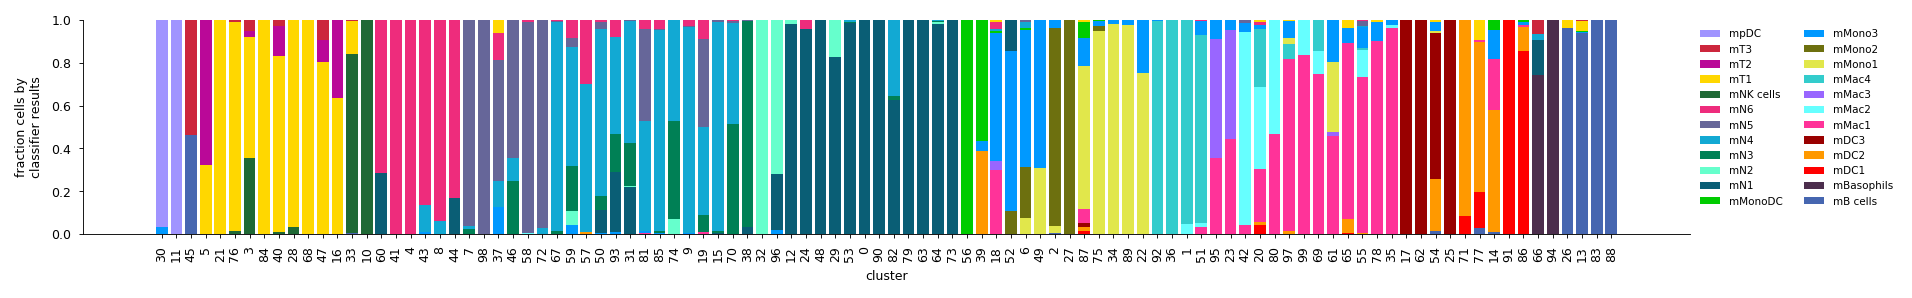

In [13]:
cell_fracs = cell_counts/cell_counts.sum()
plot_stacked_bars(cell_fracs,
                  xlabel='cluster',ylabel='fraction cells by\nclassifier results',w=40,
                  wrs=[5,1],
                  color_dict=cdd['closest_Zilionis2019_mouse_minor'],
                  save=True,comment=label)

In [14]:
# save cell numbers:
cell_counts.to_excel('outputs/cell_number_per_cluster_per_classif_result_%s.xlsx'%label)

In [15]:
# first get a dictionary for translating cluster numbers
# into annotated clusters by selecting the dominant bayesian classifier result
renamer = cell_fracs.idxmax().to_dict()

In [16]:
# translate to dominant classifier results and append colotrack to spring
newkey = 'z_dominant_class_%s'%label
cg = {newkey:[renamer[i] for i in cg0[label]]}
cdd[newkey] = cdd['closest_Zilionis2019_mouse_minor']

srz.append_cell_groupings(project_dir+plot_name,cg,colordd=cdd)

## Interactively explore the results in SPRING, force different labels where gene expression suggests so

In [17]:
# the 100 version

# B cells
thekeys = [45]
for key in thekeys:
    renamer[str(key)] = 'mPlasma' #JChain
    
# DCs
# leave the automatic assignments (as per barchart above).
# Looking at the barchart above, cluster 39 has only marginally more MonoDC-like cells
# compared to Mono2-like ones. The Mono2-like ones in cluster 39 express Mgl2, which is
# absent in MonoDCs in Zilionis et al. Immunity 2019. However, these cells are negative
# for a number of genes highly expressed in Mono2s and absent in MonoDCs (Cxcl17, Cst3, Andra2, Itgae).
# I chose to label all of the cluster 39 as suggested by the barchart above, with the caveat
# that some of the cell in 39 are Mgl2+. Notably, all healthy condition cells annotated as MonoDC 
# are Mgl2-, consistently with the Immunity 2019 paper.
    
    

# Macs
thekeys = [18] # some macs labeled as Mono3s
for key in thekeys:
    renamer[str(key)] = 'mMac1'


In [18]:
# translate to dominant classifier results and append colotrack to spring
newkey = '*population'
cg = {newkey:[renamer[i] for i in cg0[label]]}
cdd[newkey] = cdd['closest_Zilionis2019_mouse_minor']

srz.append_cell_groupings(project_dir+plot_name,cg,colordd=cdd)

## Save obs

In [30]:
label = newkey
obs[label] = np.nan
colix = np.where(obs.columns==label)[0][0]
obs.iloc[cellix,colix] = cg[label]

In [31]:
# no need to save the entire adata object, counts didn't change

fname = 'backups/obs_info_%dx%d_%s'%(obs.shape[0],obs.shape[1],rz.now())
print(fname)
rz.save_df(obs,fname)

backups/obs_info_27563x30_200629_08h53


In [32]:
obs.head()

,barcode,library,total_counts,pct_counts_mito,_library_before_renaming,mouse,condition,closest_Immgen,closest_Zilionis2019_mouse_minor,closest_Immgen_simplified,...,used_in_all_cells_clean_iter1_refCSF1Ri,sp_cl_all_cells_clean_iter1_refCSF1Ri_150,removed_as_dblt_2,used_in_all_cells_clean_iter2,sp_cl_all_cells_clean_iter2_100,*population,used_in_T_cells_only,archive_population,used_in_all_cells_clean_iter3,sp_cl_all_cells_clean_iter3_100
0,bcECPI,CSF1Ri_1_1,14875,5.81513,Blz1a,CSF1Ri_1,CSF1Ri,B1a_Sp,mB cells,B1a,...,True,19,False,True,68,mB cells,False,mB cells,True,13
1,bcESAZ,CSF1Ri_1_1,6876,4.21757,Blz1a,CSF1Ri_1,CSF1Ri,NK_DAP10-_Sp,mT3,NK,...,True,19,False,True,4,mNK cells,False,mNK cells,True,33
2,bcIBUV,CSF1Ri_1_1,4643,2.86453,Blz1a,CSF1Ri_1,CSF1Ri,GN_Arth_SynF,mN4,GN,...,True,145,False,True,75,mN4,False,mN4,True,31
3,bcGWNX,CSF1Ri_1_1,5972,6.39652,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMac1,Mo,...,True,138,False,True,41,mMac1,False,mMac1,True,18
4,bcCOWJ,CSF1Ri_1_1,5021,3.82394,Blz1a,CSF1Ri_1,CSF1Ri,Mo_6C+II-_LN,mMono1,Mo,...,True,67,False,True,1,mMono1,False,mMono1,True,89
